In [1]:
import pandas as pd
#import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [19]:
df = pd.read_csv('../processed_data/merged_data_2013-2022.csv')
df = df.drop(columns=["Unnamed: 0"])

In [3]:
# basic exploration
print(f"Dataset shape: {df.shape}")
print(f"Counties: {df['county'].nunique()}")
print(f"Years: {df['year'].unique()}")
print(f"\nMissing values: {df.isnull().sum()}")
#print(df.describe())

Dataset shape: (529, 19)
Counties: 53
Years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]

Missing values: county                                 0
year                                   0
days_with_aqi                          0
good_days                              0
moderate_days                          0
unhealthy_for_sensitive_groups_days    0
unhealthy_days                         0
very_unhealthy_days                    0
hazardous_days                         0
max_aqi                                0
90th_percentile_aqi                    0
median_aqi                             0
days_co                                0
days_no2                               0
days_ozone                             0
days_pm2.5                             0
days_pm10                              0
asthma_rate                            0
number_of_cases                        0
dtype: int64


bastic statistics of the data:

In [14]:
# which counties have the highest median aqi?
worst_aqi = df.groupby('county')['median_aqi'].mean().sort_values(ascending=False).head(10)
print("Counties with highest median AQI:")
print(worst_aqi)

# which counties have highest asthma rates?
highest_asthma = df.groupby('county')['asthma_rate'].mean().sort_values(ascending=False).head(10)
print("Counties with highest astham rates:")
print(highest_asthma)

# simple correlation analysis (pearson's correlation)
correlation = df['median_aqi'].corr(df['asthma_rate'])
print(f"Correlation between AQI and Asthma rates: {correlation:.3f}")

# simple linear regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(df['median_aqi'], df['asthma_rate'])
print(f"R-squared: {r_value**2:.3f}, P-value: {p_value:.3f}")

Counties with highest median AQI:
county
Riverside         85.6
San Bernardino    84.5
Kern              83.6
Tulare            79.0
Los Angeles       78.5
Fresno            75.5
Kings             69.7
San Diego         67.0
Imperial          62.4
Madera            61.5
Name: median_aqi, dtype: float64
Counties with highest astham rates:
county
Lake           70.638
Solano         69.643
Merced         64.923
Fresno         61.310
Kings          58.172
Sacramento     56.436
San Joaquin    55.737
Imperial       54.972
Mendocino      54.430
Humboldt       53.759
Name: asthma_rate, dtype: float64
Correlation between AQI and Asthma rates: 0.110
R-squared: 0.012, P-value: 0.011, 0.047838748615747356


simple visualizations of the relationship between aqi and asthma rates:

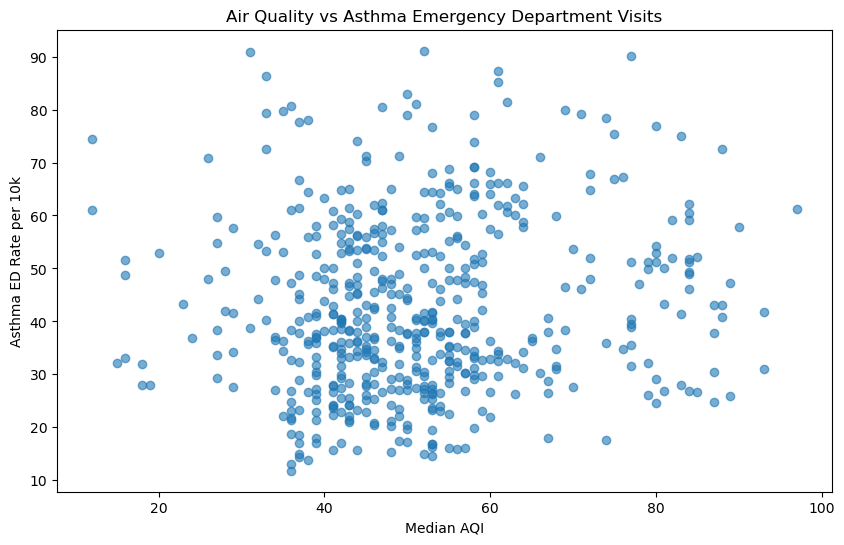

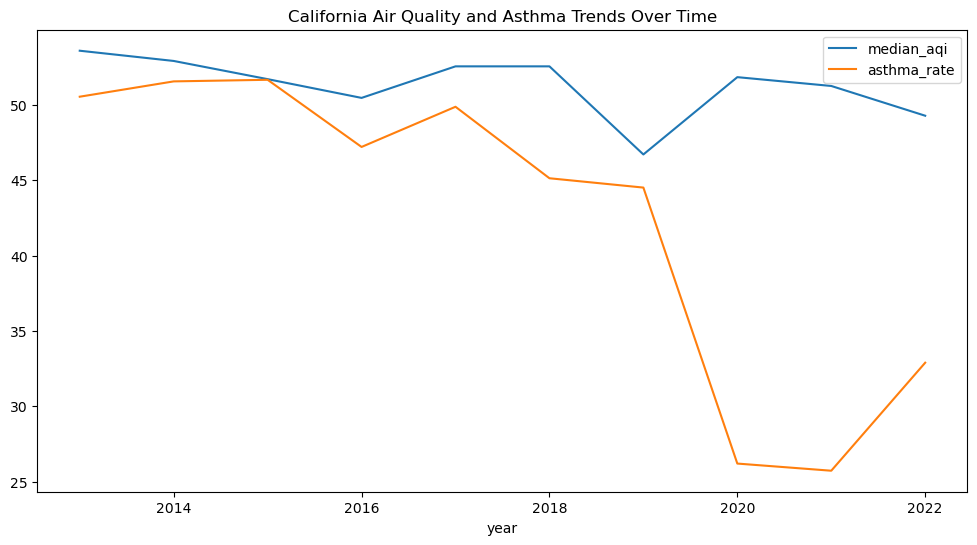

In [5]:
#  median aqi vs asthma rate - scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['median_aqi'], df['asthma_rate'], alpha=0.6)
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED Rate per 10k')
plt.title('Air Quality vs Asthma Emergency Department Visits')
plt.show()

# time trends analysis - line plot
yearly_trends = df.groupby('year')[['median_aqi', 'asthma_rate']].mean()
yearly_trends.plot(kind='line', figsize=(12, 6))
plt.title('California Air Quality and Asthma Trends Over Time')
plt.show()

looking at more factors in the relationship (aqi & asthma):

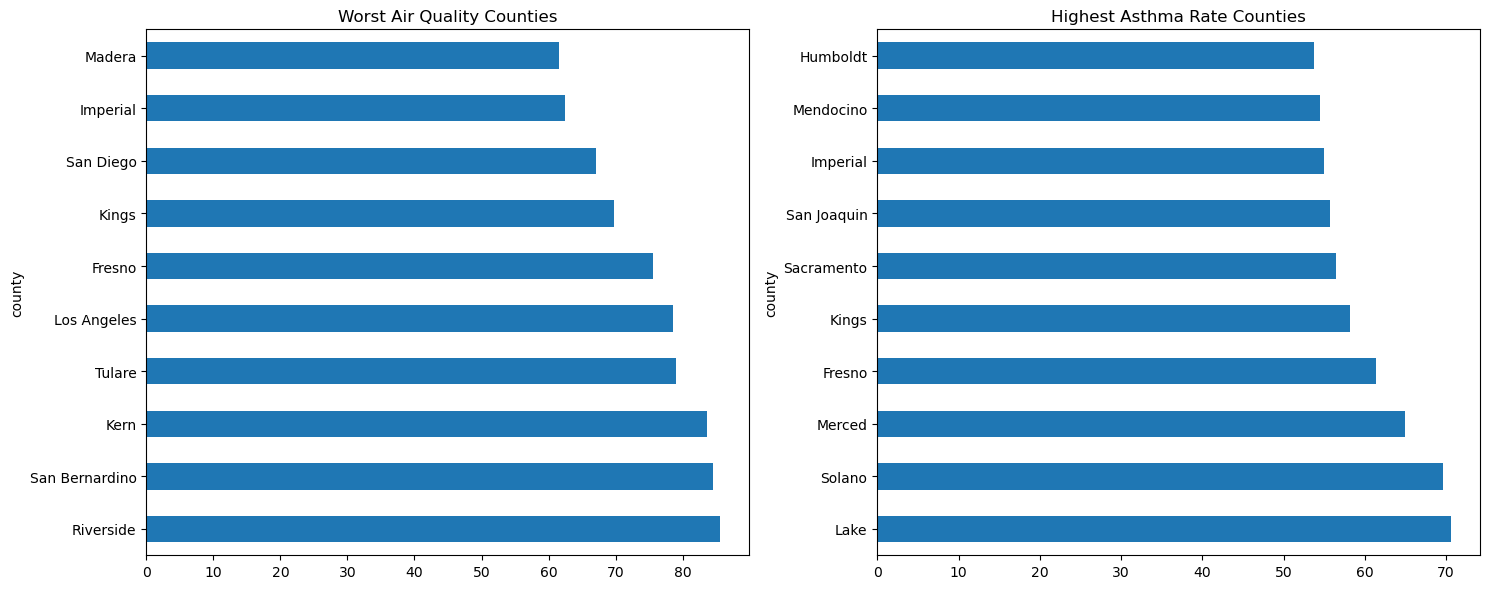

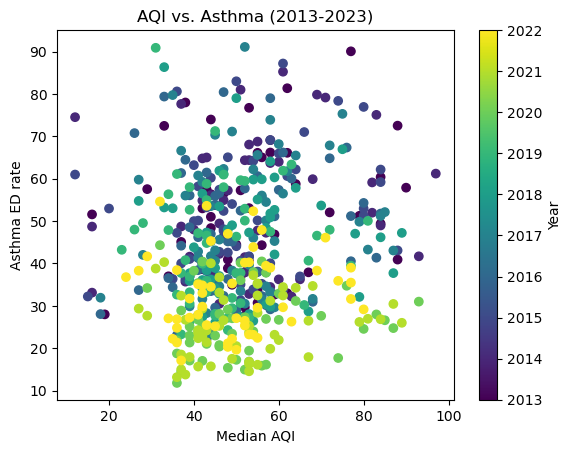

In [6]:
# top counties with worst aqi and highest asthma rates - bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
worst_aqi.head(10).plot(kind='barh', ax=ax1, title='Worst Air Quality Counties')
highest_asthma.head(10).plot(kind='barh', ax=ax2, title='Highest Asthma Rate Counties')
plt.tight_layout()
plt.show()

# median aqi vs asthma rate colored by year - scatter plot
plt.scatter(df['median_aqi'], df['asthma_rate'], c=df['year'])
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED rate')
plt.title('AQI vs. Asthma (2013-2023)')
plt.colorbar(label='Year')
plt.show()

using models to explore further on the complex relationship:

In [15]:
# simple correlation analysis (correlation coefficient)
correlation = df['median_aqi'].corr(df['asthma_rate'])
print(f"Correlation between AQI and Asthma rates: {correlation:.3f}")

# simple OLS regression model
# note: this fit does not account for the whole strength of the relationship
model = smf.ols("asthma_rate ~ median_aqi", data=df).fit()
print(model.summary())

Correlation between AQI and Asthma rates: 0.110
                            OLS Regression Results                            
Dep. Variable:            asthma_rate   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.446
Date:                Thu, 26 Jun 2025   Prob (F-statistic):             0.0114
Time:                        21:43:36   Log-Likelihood:                -2225.4
No. Observations:                 529   AIC:                             4455.
Df Residuals:                     527   BIC:                             4463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [24]:
# multiple OLS regression model
# note: more complex model but gave much more stronger relationship between aqi and asthma rate

# "aqi vs. asthma rate by county and year"
model = smf.ols('asthma_rate ~ median_aqi + C(county) + C(year)', data=df).fit()
print(
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            asthma_rate   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     52.90
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          6.40e-174
Time:                        22:53:00   Log-Likelihood:                -1677.4
No. Observations:                 529   AIC:                             3481.
Df Residuals:                     466   BIC:                             3750.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

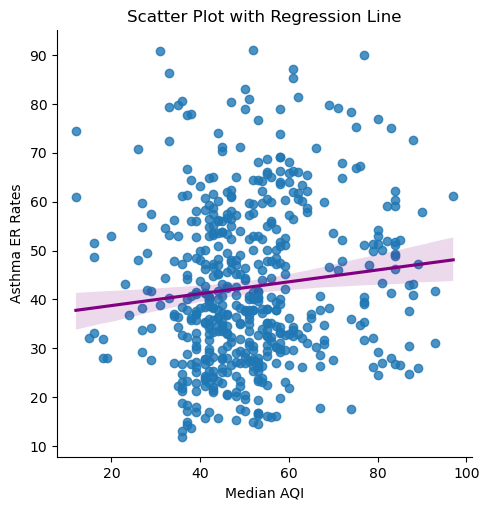

In [26]:
# Scatter plot with regression line
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.lmplot(x='median_aqi', y='asthma_rate', data=df, line_kws={'color': 'purple'})
plt.title('Scatter Plot with Regression Line')
plt.xlabel('Median AQI')
plt.ylabel('Asthma ER Rates')
plt.show()

In [22]:
# extracting the observed, predicted, and residuals
y = df['asthma_rate']
y_pred  = model.fittedvalues
residuals = df['asthma_rate'] - y_pred

visualizations of the regression results:

In [ ]:
# actual vs. predicted scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Observed asthma_rate')
plt.ylabel('Predicted asthma_rate')
plt.title('Actual vs. Predicted (Multiple OLS)')
plt.show()

# residuals distribution histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual (Observed - Predicted)')
plt.title('Residual Distribution')
plt.show()

# top county fixed effects
coefs = mod.params.filter(like='C(county)')
top_pos = coefs.sort_values(ascending=False).head(10) # plot top 10 positive
top_neg = coefs.sort_values().head(10) # plot top 10 negative
plot_coefs = pd.concat([top_pos, top_neg])

plt.figure(figsize=(8,6))
plot_coefs.plot(kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Negative & Positive County Fixed Effects')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import numpy as np

In [10]:
# Split merged df into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fit the OLS on the training set
mod = smf.ols('asthma_rate ~ median_aqi + C(county) + C(year)', data=train_df).fit()

# Predict on test set
test_df['y_pred_test'] = mod.predict(test_df)

# Evaluate
mse_test = mean_squared_error(test_df['asthma_rate'], test_df['y_pred_test'])
rmse_test = np.sqrt(mse_test)
print("Test-set RMSE:", rmse_test)

Test-set RMSE: 7.473580216504066


In [11]:
mean_rate = df['asthma_rate'].mean()
relative_rmse = rmse_test / mean_rate
print(relative_rmse)

0.17562529888684628
